# Example: Area Detector & HDF5 File (default)

**Objective**

Demonstrate and explain the setup of an [EPICS area detector](https://areadetector.github.io/master/index.html) to acquire an image with [bluesky](https://blueskyproject.io/) and write it to an [HDF5](https://www.hdfgroup.org/solutions/hdf5) file.  Use the standard [ophyd conventions](https://blueskyproject.io/ophyd) for file naming and other setup.  Show how to retrieve the image using the [databroker](https://blueskyproject.io/databroker).

**Contents**

- [EPICS Area Detector IOC](#epics-area-detector-ioc) is pre-built
- [File Directories](#file-directories) are different on IOC and bluesky workstation
- [ophyd](#ophyd) to describe the hardware
- [bluesky](#bluesky) for the measurement
- [databroker](#databroker) to view the image

See also:

- [Example with custom file names](_ad_adsim_hdf5_custom_names.ipynb)
- [ADPilatus example](_ad_pilatus.rst)
- [ADPerkinElmer example](_ad_pe.rst)

## EPICS Area Detector IOC

This example uses a prebuilt [ADSimDetector](https://areadetector.github.io/master/ADSimDetector/simDetector.html) driver, packaged in a [docker](https://www.docker.com/) image
([prjemian/custom-synapps-6.2-ad-3.10](https://hub.docker.com/r/prjemian/custom-synapps-6.2-ad-3.10/tags)).  The [EPICS IOC](https://docs.epics-controls.org/projects/how-tos/en/latest/getting-started/creating-ioc.html) is configured with prefix `ad:` using the [bash shell script](https://github.com/prjemian/epics-docker/blob/main/v1.1/n6_custom_areaDetector/start_adsim.sh):

```bash
start_adsim.sh ad
```

In [1]:
IOC = "ad:"

## File Directories

Files from the IOC are mounted on the docker host in the directory `/tmp/docker_ioc/iocad`. The bluesky session runs on the docker host.

system | file directory
--- | ---
area detector IOC | `/tmp`
bluesky | `/tmp/docker_ioc/iocad/tmp`

It is important to understand that, while the EPICS IOC and the Python process where the user interacts (with bluesky and databroker) should both see the same image file written by acquisition, the directory path to that file may be different on the two systems. Typically, the file system is mounted on both (IOC & Python) at the time of acquisition, perhaps at different mount points on each. Alternatively, the image file written by the IOC may be copied to a directory where Python can find the file **when** the user attempts to read image data via databroker.

For convenience now and later, define these two directories using [pathlib](https://docs.python.org/3/library/pathlib.html), from the Python standard library.

In [2]:
import pathlib

AD_IOC_MOUNT_PATH = pathlib.Path("/tmp")
BLUESKY_MOUNT_PATH = pathlib.Path("/tmp/docker_ioc/iocad/tmp")

Image files are written to a subdirectory (*image directory*) of the mount path.  In this case, we use a feature of the area detector [HDF5 file writer](https://areadetector.github.io/master/ADCore/NDFileHDF5.html) plugin that accepts [time format codes](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-format-codes), such as `%Y` for year, to build the image directory path based on the current date.  Here, we created an example directory with suibdirectory for year, month, and day (such as: `example/2022/07/04`):

In [3]:
IMAGE_DIR = "example/%Y/%m/%d"

  Using the two pathlib objects created above, create two string objects for configuration of the HDF5 plugin.  The area detector IOC expects each string to end with a `/` character but will add it if it is not provided.  But ophyd requires the value sent to EPICS to match exactly the value that the IOC reports, thus we make the correct ending here.

In [4]:
# MUST end with a `/`, pathlib will NOT provide it
WRITE_PATH_TEMPLATE = f"{AD_IOC_MOUNT_PATH / IMAGE_DIR}/"
READ_PATH_TEMPLATE = f"{BLUESKY_MOUNT_PATH / IMAGE_DIR}/"

## ophyd

In ophyd, the support for hardware that has multiple PVs is constructed as a subclass of `ophyd.Device`.  The EPICS area detector is described with a special subclass called `ophyd.areadetector.DetectorBase`.  An area detector has a detector driver, called a `cam` in the ophyd support, which is another subclass.  Each of the plugins (image, PVA, HDF5, ...) has its own subclass.  The general structure is:

```
DetectorBase
    CamBase
    ImagePlugin
    HDF5Plugin
    PvaPlugin
    ...
```

TODO: write about what plugins are needed.
cite: https://blueskyproject.io/ophyd/explanations/area-detector.html?highlight=singletrigger#ports

### cam

The principle difference between area detector drivers is the `cam` support, which is specific to the detector driver being configured.  All the other plugin support is independent of the `cam` support.  Follow these steps to implement for a different detector driver.

The [ophyd package](https://blueskyproject.io/ophyd/explanations/area-detector.html#specific-hardware) has support for many of the area detector drivers.  A complete list is available in the [ophyd source code](https://github.com/bluesky/ophyd/blob/master/ophyd/areadetector/cam.py).

The ADSimDetector driver is in this list, as `SimDetectorCam`.  But the ophyd support is out of date for the EPICS area detector release 3.10 used here, so we need to make modifications with a subclass, as is typical.  The changes we see were introduced in ADSimDetector v3.1.1.

The `pool_max_buffers` is no longer supported, so the attribute defined in `SimDetectorCam` is disabled by setting the attribute to `None`.  Three new PVs are added as `ADComponent` objects.

We'll also add a convenience *property* method, `is_acquire_busy`, to make it easy to use the new `AcquireBusy` PV when waiting for acquisition to finish.

In [5]:
from ophyd.areadetector import SimDetectorCam
from ophyd import ADComponent
from ophyd import EpicsSignal
from ophyd import EpicsSignalRO
from ophyd import EpicsSignalWithRBV

class SimDetectorCam_R3_1_1(SimDetectorCam):
    """Revise SimDetectorCam for ADCore revisions."""
    pool_max_buffers = None
    offset = ADComponent(EpicsSignalWithRBV, "Offset")
    acquire_busy = ADComponent(EpicsSignalRO, "AcquireBusy ")
    wait_for_plugins = ADComponent(EpicsSignal, "WaitForPlugins")

    @property
    def is_acquire_busy(self):
        signal = self.acquire_busy
        return signal.get() in (1, signal.enum_strs[1])

### HDF5

Support for writing images to HDF5 files using the area detector HDF5 File Writer plugin comes from the `HDF5Plugin`.  This [plugin](https://github.com/bluesky/ophyd/blob/master/ophyd/areadetector/plugins.py) cames in different versions.  The ophyd support may be out of date, but in this case it is not if we pick the `HDF5Plugin_V34` version.  The plugin provides bare support which needs some modification for the manner of acquisition.

Here we build a custom HDF5 plugin class with `FileStoreHDF5IterativeWrite`.  This mixin class configures the HDF5 plugin to collect one or more images and writes file name and path and HDF5 address information of each frame in the data stream.

In [6]:
from ophyd.areadetector.filestore_mixins import FileStoreHDF5IterativeWrite
from ophyd.areadetector.plugins import HDF5Plugin_V34 as HDF5Plugin

class MyHDF5Plugin(FileStoreHDF5IterativeWrite, HDF5Plugin):
    """Run HDF5 plugin in 'Single' mode."""

### detector

The detector class, a subclass of `DetectorBase`, brings together the detector driver `cam` and plugins.  This class will be used to build the Python object for the detector.  In addition to the `cam` and HDF5 plugin, we'll enable the image plugin (`ImagePlugin`) so that a client viewer can view the image.

The `SingleTrigger` mixin class configures the `cam` for data acquisition as [explained](https://blueskyproject.io/ophyd/explanations/area-detector.html?highlight=singletrigger#callbacks).

<!--  This suggested modification is not yet a standard convention:

Needs more packages to be installed.

To convert an existing area detector sub-class to support the new scheme you must:

    Change the type of the came to sub-class nslsii.ad33.CamV33Mixin

    Change the trigger mixin to be nslsii.ad33.SingleTriggerV33

    Arrange for det.cam.ensure_nonblocking to be called after initializing the ophyd object.

Addition of the [nslsii package](https://anaconda.org/conda-forge/nslsii) requires
additional packages such as kafka, that will not be used here.  Better to
(re)implement the code, from:
https://github.com/NSLS-II/nslsii/blob/9cd77e0aa24d59fddf534948b9b97dacb0832ed2/nslsii/ad33.py#L37
-->

When configuring the custom `MyHDF5Plugin` class, we apply the two strings defined above for the file paths on the IOC (write) and on the bluesky workstation (read).

In [7]:
from ophyd.areadetector import DetectorBase
from ophyd.areadetector import SingleTrigger
from ophyd.areadetector.plugins import ImagePlugin_V34 as ImagePlugin

class MySimDetector(SingleTrigger, DetectorBase):
    """
    ADSimDetector

    SingleTrigger:

    * stop any current acquisition
    * sets image_mode to 'Multiple'
    """

    cam = ADComponent(SimDetectorCam_R3_1_1, "cam1:")
    hdf1 = ADComponent(
        MyHDF5Plugin,
        "HDF1:",
        write_path_template=WRITE_PATH_TEMPLATE,
        read_path_template=READ_PATH_TEMPLATE,
    )
    image = ADComponent(ImagePlugin, "image1:")

With all the above setup, create the Python detector object, `adsimdet` and wait for it to connect with EPICS.

In [8]:
adsimdet = MySimDetector(IOC, name="adsimdet")
adsimdet.wait_for_connection(timeout=15)

Check that all plugins used by the IOC have been defined in the Python structure.  Expect that this function returns an empty list: `[]`.

In [9]:
adsimdet.missing_plugins()

[]

We must configure `det` so the HDF5 plugin (by its attribute name `hdf1`) will be called during `adsimdet.read()`, as used by data acquisition.

In [10]:
adsimdet.read_attrs.append("hdf1")

Configure the HDF5 plugin so it will create up to 5 subdirectories for the image directory.  We *must* do this step before staging so the IOC is prepared when the `FilePath` PV is set during `adsimdet.stage()`.

In [11]:
adsimdet.hdf1.create_directory.put(-5)

As [advised](https://github.com/BCDA-APS/apstools/issues/671), apply this change affecting how the area detector will report completion of an acquisition.

*Upgrade*: Make the [change for the SingleTrigger mixin](https://blueskyproject.io/ophyd/explanations/area-detector.html?highlight=singletrigger#callbacks) as recommended.  [NSLS-II code](https://github.com/NSLS-II/nslsii/blob/9cd77e0aa24d59fddf534948b9b97dacb0832ed2/nslsii/ad33.py#L37)

<!--  This suggested modification is not yet a standard convention:

To convert an existing area detector sub-class to support the new scheme you must:

    Change the type of the came to sub-class nslsii.ad33.CamV33Mixin

    Change the trigger mixin to be nslsii.ad33.SingleTriggerV33

    Arrange for det.cam.ensure_nonblocking to be called after initializing the ophyd object.
-->

In [12]:
# override default setting from ophyd
adsimdet.hdf1.stage_sigs["blocking_callbacks"] = "No"
adsimdet.hdf1.stage_sigs["parent.cam.wait_for_plugins"] = "Yes"

Consider enabling and setting any of these additional configurations as appropriate to your situation.  Here, we accept the default acquisition time, but acquire 5 frames with `zlib` data compression.

In [13]:
# adsimdet.cam.stage_sigs["acquire_period"] = 0.015
# adsimdet.cam.stage_sigs["acquire_time"] = 0.01
adsimdet.cam.stage_sigs["num_images"] = 5
adsimdet.cam.stage_sigs["parent.hdf1.num_capture"] = adsimdet.cam.stage_sigs["num_images"]
adsimdet.hdf1.stage_sigs["compression"] = "zlib"
# det.hdf1.stage_sigs["lazy_open"] = "Yes"

Always, make the `capture` be the last signal to be staged.

In [14]:
adsimdet.hdf1.stage_sigs.move_to_end("capture", last=True)

Print some values as diagnostics.

In [15]:
adsimdet.read_attrs

['hdf1']

In [16]:
adsimdet.stage_sigs

OrderedDict([('cam.acquire', 0), ('cam.image_mode', 1)])

In [17]:
adsimdet.cam.stage_sigs

OrderedDict([('num_images', 5), ('parent.hdf1.num_capture', 5)])

In [18]:
adsimdet.hdf1.stage_sigs

OrderedDict([('enable', 1),
             ('blocking_callbacks', 'No'),
             ('parent.cam.array_callbacks', 1),
             ('create_directory', -3),
             ('auto_increment', 'Yes'),
             ('array_counter', 0),
             ('auto_save', 'Yes'),
             ('num_capture', 0),
             ('file_template', '%s%s_%6.6d.h5'),
             ('file_write_mode', 'Stream'),
             ('parent.cam.wait_for_plugins', 'Yes'),
             ('compression', 'zlib'),
             ('capture', 1)])

Even though area detector has a `LazyOpen` feature, ophyd needs to know how to describe the image structure before it starts saving data.  If the file writing (HDF5) plugin does not have the dimensions, bit depth, color mode, ... of the expected image, then ophyd does not have access to the metadata it needs.

This code checks if the plugin is ready and, if not, makes the plugin ready by acquiring (a.k.a. *priming*) a single image into the plugin.

In [19]:
from apstools.devices import AD_plugin_primed
from apstools.devices import AD_prime_plugin2

# this step is needed for ophyd
if not AD_plugin_primed(adsimdet.hdf1):
    print(f"Priming {adsimdet.hdf1.dotted_name}")
    AD_prime_plugin2(adsimdet.hdf1)

## bluesky

Within the [Bluesky framework](https://blueskyproject.io/), [bluesky](https://blueskyproject.io/bluesky) is the package that orchestrates the data acquisition steps, including where to direct acquired data for storage.  [Later](#databroker), we'll use [databroker](https://blueskyproject.io/databroker) to access the image data.

As a first step, configure the notebook for graphics.  (While `%matplotlib inline` works well for documentation, you might prefer the additional interactive features possible by changing to `%matplotlib widget`.)

In [20]:
# Import matplotlib for inline graphics
%matplotlib inline
import matplotlib.pyplot as plt

plt.ion()

We'll use a temporary databroker catalog for this example. You may wish to use your own catalog:

```py
cat = databroker.catalog[YOUR_CATALOG_NAME]
```

Then setup the bluesky run engine `RE`, connect it with the databroker catalog, and enable (via `BestEffortCallback`) some screen output during data collection.

In [21]:
from bluesky import plans as bp
from bluesky import RunEngine
from bluesky import SupplementalData
from bluesky.callbacks.best_effort import BestEffortCallback
import databroker

cat = databroker.temp().v2
RE = RunEngine({})
RE.subscribe(cat.v1.insert)
RE.subscribe(BestEffortCallback())
RE.preprocessors.append(SupplementalData())

**Take an image with the area detector.**  Also,  capture the list of identifiers (there will be only one item). Add custom metadata to identify the imaging run.

Note that the HDF plugin will report, briefly before acquisition, (in its `WriteMessage` PV):

> ERROR: capture is not permitted in Single mode

Ignore that.  (TODO: modify the SingleTrigger mixin with respect to `capture`.)

In [22]:
uids = RE(bp.count([adsimdet], md=dict(title="Area Detector with HDF5 plugin", purpose="image")))



Transient Scan ID: 1     Time: 2022-08-04 17:42:49
Persistent Unique Scan ID: '2deb8980-1f14-4b30-a9e5-39a7b53052f1'
New stream: 'primary'
+-----------+------------+
|   seq_num |       time |
+-----------+------------+
|         1 | 17:42:50.0 |
+-----------+------------+
generator count ['2deb8980'] (scan num: 1)





## databroker

To emphasize the decisions associated with each step to get the image data, the procedure is shown in parts.

***Get the run from the catalog***

The run data comes from the databroker catalog.  We *could* assume we want the most recent run in the catalog (`run = cat.v2[-1]`). But, since we have a list of run *uid* strings, let's use that instead.   If we wanted to access this run later, when neither of those two choices are possible, then the run could be access by its *Transient Scan ID* as reported above: `run = cat.v2[1]`

There are three ways to reference a run in the catalog:

argument | example | description
--- | --- | ---
negative integer | `cat.v2[-1]` | ***list*-like**, `-1` is most recent, `-2` is 2nd most recent, ...
positive integer | `cat.v2[1]` | argument is the **Scan ID** (if search is not unique, returns most recent)
string | `cat.v2["a1b2c3d"]` | argument is a **`uid`** (just the first few characters that make the catalog search unique are needed)

We called the `RE` with `bp.count()`, which only generates a single run, so there is no assumption here using the `uids` list from this session.

In [23]:
run = cat.v2[uids[0]]
run

BlueskyRun
  uid='2deb8980-1f14-4b30-a9e5-39a7b53052f1'
  exit_status='success'
  2022-08-04 17:42:49.988 -- 2022-08-04 17:42:50.098
  Streams:
    * primary


***Get the image frame from the run***

From the run, we know the image data is in the primary stream.  (In fact, that is the only stream in this run.)  Get the run's data as an [xarray Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) object.

In [24]:
dataset = run.primary.read()
dataset

<xarray.Dataset>
Dimensions:         (time: 1, dim_0: 3, dim_1: 1024, dim_2: 1024)
Coordinates:
  * time            (time) float64 1.66e+09
Dimensions without coordinates: dim_0, dim_1, dim_2
Data variables:
    adsimdet_image  (time, dim_0, dim_1, dim_2) uint8 5 8 6 3 2 3 ... 7 5 5 9 8

The image is recorded under the name `"adsimdet_image"`. This `image` object has rank of 4 (1 timestamp and 5 frames of 1k x 1k).

In [25]:
image = dataset["adsimdet_image"]
# image is an xarray.DataArray with 1 timestamp and 5 frames of 1k x 1k

 We just want the `image` frame (the last two indices). Select the first item of each of the first two indices (time, frame number)

In [26]:
frame = image[0][0]
# frame is an xarray.DataArray of 1k x 1k


***Visualize the image***

The `frame` is an [xarray Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html), which has a method to visualize the data as shown here:

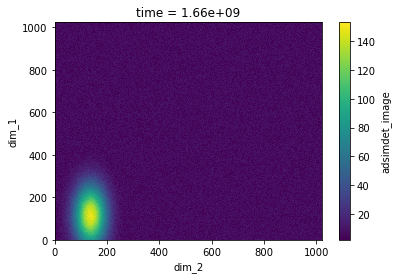

In [27]:
frame.plot.pcolormesh()

In [28]:
run.primary._resources

[Resource({'path_semantics': 'posix',
 'resource_kwargs': {'frame_per_point': 5},
 'resource_path': 'tmp/docker_ioc/iocad/tmp/example/2022/08/04/1635d29f-d814-4403-b675_000000.h5',
 'root': '/',
 'run_start': '2deb8980-1f14-4b30-a9e5-39a7b53052f1',
 'spec': 'AD_HDF5',
 'uid': '47c8c445-a4d3-4ac8-bed3-64c8f55440b3'})]

***Find the image file on local disk***

We can get the name of the image file on the bluesky (local) workstation from the `det` object.

In [29]:
from apstools.devices import AD_full_file_name_local

lfname = AD_full_file_name_local(adsimdet.hdf1)
print(f"{lfname.exists()=}\n{lfname=}")

lfname.exists()=True
lfname=PosixPath('/tmp/docker_ioc/iocad/tmp/example/2022/08/04/1635d29f-d814-4403-b675_000000.h5')


Alternatively, we might get the name of the file from the run stream.

In [30]:
rsrc = run.primary._resources[0]
fname = pathlib.Path(f"{rsrc['root']}{rsrc['resource_path']}")
print(f"{fname.exists()=}\n{fname=}")

fname.exists()=True
fname=PosixPath('/tmp/docker_ioc/iocad/tmp/example/2022/08/04/1635d29f-d814-4403-b675_000000.h5')


Using the [punx](https://punx.readthedocs.io) program, read this HDF5 file and shows its tree structure.

In [31]:
from apstools.utils import unix

for line in unix(f"punx tree {lfname}"):
    print(line.decode().strip())

!!! WARNING: this program is not ready for distribution.

/tmp/docker_ioc/iocad/tmp/example/2022/08/04/1635d29f-d814-4403-b675_000000.h5 : NeXus data file
  entry:NXentry
    @NX_class = "NXentry"
    data:NXdata
      @NX_class = "NXdata"
      data:NX_UINT8[3,1024,1024] = __array
        __array = [
            [
                [5, 8, 6, '...', 8]
                [7, 10, 4, '...', 6]
                [11, 2, 7, '...', 3]
                ...
                [5, 10, 6, '...', 11]
              ]
            [
                [5, 9, 2, '...', 8]
                [9, 10, 2, '...', 6]
                [9, 3, 8, '...', 9]
                ...
                [10, 7, 9, '...', 8]
              ]
            [
                [8, 3, 11, '...', 10]
                [9, 9, 10, '...', 5]
                [10, 10, 7, '...', 6]
                ...
                [11, 2, 2, '...', 8]
              ]
          ]
        @NDArrayDimBinning = [1 1]
        @NDArrayDimOffset = [0 0]
        @NDArrayDimRev